# Fine-Tuning DistilBERT for Financial Sentiment Classification

In [1]:
!pip install --upgrade transformers evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.2 MB/s eta 0:00:00


In [2]:
!git lfs install

Git LFS initialized.


In [3]:
!git clone https://huggingface.co/datasets/zeroshot/twitter-financial-news-sentiment

Cloning into 'twitter-financial-news-sentiment'...
remote: Enumerating objects: 139, done.
remote: Total 139 (delta 0), reused 0 (delta 0), pack-reused 139 (from 1)
Receiving objects: 100% (139/139), 1.52 MiB | 25.51 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [4]:
from datasets import load_dataset
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
import evaluate

In [5]:
!head /content/twitter-financial-news-sentiment/sent_train.csv

text,label
$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT,0
$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3,0
"$CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb",0
$ESS: BTIG Research cuts to Neutral https://t.co/MCyfTsXc2N,0
$FNKO - Funko slides after Piper Jaffray PT cut https://t.co/z37IJmCQzB,0
$FTI - TechnipFMC downgraded at Berenberg but called Top Pick at Deutsche Bank https://t.co/XKcPDilIuU,0
$GM - GM loses a bull https://t.co/tdUfG5HbXy,0
$GM: Deutsche Bank cuts to Hold https://t.co/7Fv1ZiFZBS,0
$GTT: Cowen cuts to Market Perform,0


In [6]:
#dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")
local_dataset_file = "/content/twitter-financial-news-sentiment/sent_train.csv"
#dataset = load_dataset("csv", data_files=local_dataset_file, split="train")
df = pd.read_csv(local_dataset_file)
dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 7634
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1909
    })
})

In [7]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_fn(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

tokenized = dataset.map(tokenize_fn, batched=True)

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

training_args = TrainingArguments(
    output_dir="./custom_sentiment_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    load_best_model_at_end=True,
    report_to="none"
)

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return accuracy.compute(predictions=preds, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<ipython-input-7-49ef37bda2ff>:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [8]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.443774,0.850707
2,0.498300,0.501794,0.858041
3,0.240100,0.589882,0.862232


TrainOutput(global_step=1434, training_loss=0.29180137815169543, metrics={'train_runtime': 500.5554, 'train_samples_per_second': 45.753, 'train_steps_per_second': 2.865, 'total_flos': 3033822466971648.0, 'train_loss': 0.29180137815169543, 'epoch': 3.0})

In [9]:
model_path = "./custom_sentiment_model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print(f"✅ Model saved to: {model_path}")

✅ Model saved to: ./custom_sentiment_model


In [12]:
# Evaluate on the test set
local_test_dataset_file = "/content/twitter-financial-news-sentiment/sent_valid.csv"
#dataset = load_dataset("csv", data_files=local_dataset_file, split="train")
test_df = pd.read_csv(local_test_dataset_file)
test_dataset = Dataset.from_pandas(test_df)

def preprocess(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

tokenized_test = test_dataset.map(preprocess, batched=True)


print("🔍 Running evaluation on test set...")
eval_metrics = trainer.evaluate(tokenized_test)
print("Evaluation Metrics:")
print(eval_metrics)

Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

🔍 Running evaluation on test set...


Evaluation Metrics:
{'eval_loss': 0.3761230707168579, 'eval_accuracy': 0.8672529313232831, 'eval_runtime': 17.3114, 'eval_samples_per_second': 137.944, 'eval_steps_per_second': 8.665, 'epoch': 3.0}



📊 Classification Report:
              precision    recall  f1-score   support

     Bearish       0.82      0.72      0.77       347
     Bullish       0.77      0.83      0.80       475
     Neutral       0.91      0.91      0.91      1566

    accuracy                           0.87      2388
   macro avg       0.83      0.82      0.83      2388
weighted avg       0.87      0.87      0.87      2388



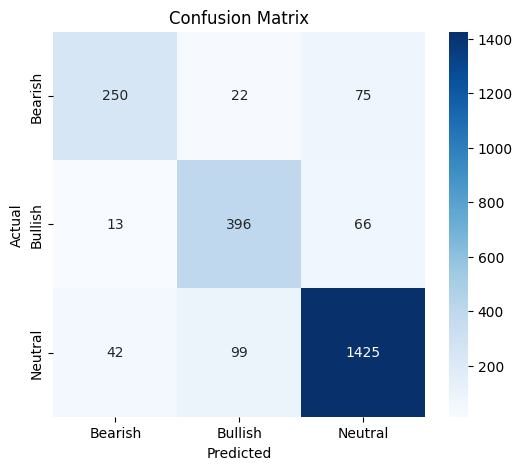

In [13]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

print("\n📊 Classification Report:")
target_names = ["Bearish", "Bullish", "Neutral"]
print(classification_report(labels, preds, target_names=target_names))

cm = confusion_matrix(labels, preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [14]:
!zip -r custom_sentiment_model.zip custom_sentiment_model

  adding: custom_sentiment_model/ (stored 0%)
  adding: custom_sentiment_model/model.safetensors (deflated 8%)
  adding: custom_sentiment_model/vocab.txt (deflated 53%)
  adding: custom_sentiment_model/tokenizer_config.json (deflated 75%)
  adding: custom_sentiment_model/config.json (deflated 49%)
  adding: custom_sentiment_model/checkpoint-1434/ (stored 0%)
  adding: custom_sentiment_model/checkpoint-1434/model.safetensors (deflated 8%)
  adding: custom_sentiment_model/checkpoint-1434/rng_state.pth (deflated 25%)
  adding: custom_sentiment_model/checkpoint-1434/vocab.txt (deflated 53%)
  adding: custom_sentiment_model/checkpoint-1434/optimizer.pt (deflated 29%)
  adding: custom_sentiment_model/checkpoint-1434/tokenizer_config.json (deflated 75%)
  adding: custom_sentiment_model/checkpoint-1434/config.json (deflated 49%)
  adding: custom_sentiment_model/checkpoint-1434/scheduler.pt (deflated 56%)
  adding: custom_sentiment_model/checkpoint-1434/tokenizer.json (deflated 71%)
  adding: c